# The Great 2011 Tohoku earthquake and the Fukushima Daiichi Accident: An Analysis

> The Tohoku earthquake was the most powerful earthquake ever recorded in Japan, and the fourth most powerful earthquake in the world since modern record-keeping began in 1900. This notebook is an analysis into the earthquakes in Japan and how frequently Japan should expect earthquakes of varying magnitude based on linear regression

- toc: true
- branch: master
- author: Michael Hotaling
- badges: true
- comments: true
- categories: [jupyter,matplotlib,python,model,linear,machine learning]
- hide: false
- image: images/stocks.jpeg
- show_image: true
- permalink: /japan-earthquakes/
- hide_binder_badge: false
- hide_colab_badge: false


In [1]:
# Hide
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import geopandas as gpd
import folium

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
#Hide
df = pd.read_csv("/kaggle/input/earthquakes-in-japan/Japan earthquakes 2001 - 2018.csv")

In [3]:
#Hide
df['popup'] = pd.to_datetime(df['time']).dt.strftime("%Y-%m-%d")+": Magnitude "+df['mag'].astype(str)+": "+df['place'].str.upper()

In [4]:
#Hide
# Loading the background map
eq_map = folium.Map(location=[37.973265, 142.597713], zoom_start=5, tiles='Stamen Terrain', width=1250)
fg = folium.FeatureGroup(name="My Map")

# Adding a circle for each earthquake
for idx, eq in df.query('mag >= 6').iterrows():
    #folium.Circle(location=(eq['latitude'], eq['longitude']), radius=20000 * (eq['mag']-6), color='red', fill=False, alpha = 0.4).add_to(eq_map)
    fg.add_child(folium.CircleMarker(location=[eq['latitude'], 
                                               eq['longitude']], 
                                     radius=10 * (eq['mag']-6), 
                                     color = 'red', 
                                     fill_color='red', 
                                     fill_opacity=0.4, 
                                     popup=eq['popup']))
    
eq_map.add_child(fg)
folium.Circle(location = (37.4218, 141.0337), color = 'yellow', fill_color = 'yellow', radius = 2000, popup="Fukushima Daiichi", fill_opacity=0.4).add_to(eq_map)
eq_map

In [5]:
#Hide
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries = ['Japan','Fiji','China','Russia','South Korea','North Korea','Mongolia']
japan_gdf = world.query("name in @countries")

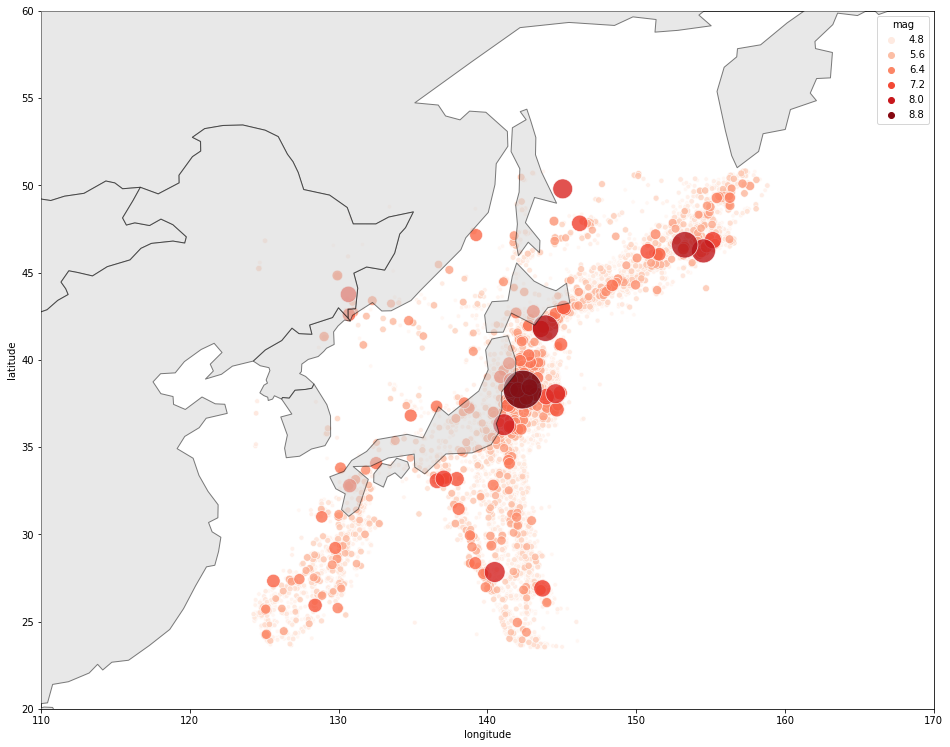

In [6]:
fig, ax = plt.subplots(figsize=(16,16))
japan_gdf.plot(color =  'lightgray', edgecolor = 'k', ax =ax, zorder = 10, alpha = 0.5)
df.sort_values('mag', inplace=True)
sns.scatterplot(x = df['longitude'], 
                y = df['latitude'], 
                hue = df['mag'],
                s = 2.6**df['mag'],
                #sizes=(minsize, maxsize),
                ax = ax, 
                alpha = 0.8, palette= 'Reds',marker = '.');
plt.xlim(110,170)
plt.ylim(20,60)
plt.show();

<AxesSubplot:xlabel='mag', ylabel='freq'>

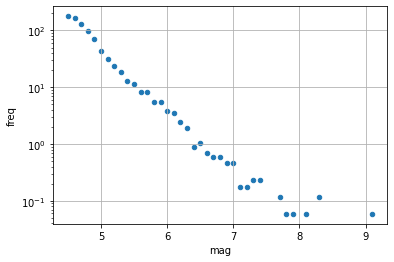

In [7]:
freq = (df
         .mag
         .value_counts()
         .sort_index()
         .rename_axis('mag')
         .reset_index(name='counts')
         .assign(freq = lambda x: x.counts/(pd.to_datetime(df['time']).dt.year.max() - \
                                            pd.to_datetime(df['time']).dt.year.min()))
       #  .drop(['counts'], axis =1)
      #   .query('mag <= 6.5')
      .assign(log_freq = lambda x: np.log10(x.freq))
        )
(freq
.plot
.scatter(x = 'mag', y = 'freq', logy=True, grid = True)
)

In [8]:
X = np.array(freq['mag']).reshape(-1,1)
y = np.array(freq['log_freq']).reshape(-1,1)
s = np.array(freq['counts'])

In [9]:
lm = LinearRegression()

lm.fit(X,y,s)

print(f"log10(Frequency) = {lm.coef_[0][0]:.2f}*[Magnitude] + {lm.intercept_[0]:.2f}\n")
print(f"Frequency = 10**({lm.coef_[0][0]:.2f}*[Magnitude] + {lm.intercept_[0]:.2f})")

log10(Frequency) = -1.17*[Magnitude] + 7.57

Frequency = 10**(-1.17*[Magnitude] + 7.57)


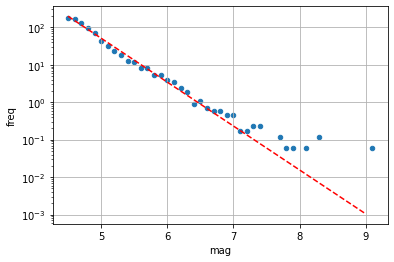

In [10]:
(freq
.plot
.scatter(x = 'mag', y = 'freq', logy=True, grid = True)
)
plt.plot(np.arange(4.5,9.1,0.1), 
         10**lm.predict(np.arange(4.5,9.1,0.1).reshape(-1,1)), 
         color = 'red', 
         linestyle = "--")